# Welcome to the Google Local Reviews Dataset  Workshop
This is a jupyter notebook and I'm going to be covering some basics about the Google local reviews dataset so that you have direction to go with and you don't have to worry too much about the pipelining. Before we start lets import some important libraries that we will need. 

In [44]:
# import libraries
import os
import io
import json
import gzip
from collections import defaultdict # shoutout
import numpy as np
import random

In [2]:
# list current directory
os.listdir()

['.DS_Store',
 'places.clean.json.gz',
 'sample.reviews.json',
 'users.clean.json.gz',
 'GoogleLocalReviews Workshop.ipynb',
 'reviews.clean.json.gz',
 '.ipynb_checkpoints',
 '.git']

## What is json.gz?  
It is essentially a zipped or compressed version of a json file. 

In [10]:
# read in a gz file
def readGz(fname):
    gz = gzip.open(fname, 'rb')
    f = io.BufferedReader(gz)
    data = []
    
    count = 0
    
    for l in f.readlines():
        data.append(eval(l))
        count += 1
        
        if count % 10 == 0: break
        
    gz.close()
    return data
    
# places = readGz("places.clean.json.gz")

In [4]:
places[0]

{'name': 'Diamond Valley Lake Marina',
 'price': None,
 'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
 'hours': [['Monday', [['6:30 am--4:15 pm']]],
  ['Tuesday', [['6:30 am--4:15 pm']]],
  ['Wednesday', [['6:30 am--4:15 pm']], 1],
  ['Thursday', [['6:30 am--4:15 pm']]],
  ['Friday', [['6:30 am--4:15 pm']]],
  ['Saturday', [['6:30 am--4:15 pm']]],
  ['Sunday', [['6:30 am--4:15 pm']]]],
 'phone': '(951) 926-7201',
 'closed': False,
 'gPlusPlaceId': '104699454385822125632',
 'gps': [33.703804, -117.003209]}

In [14]:
users = readGz("users.clean.json.gz")

users[5]

{'userName': 'Jacquelyn Dorris',
 'jobs': [['PS Medical Supplies, Inc.',
   'Customer Service',
   [[1, 1, 2012], [1, 1, 2013], 1],
   '',
   '']],
 'currentPlace': ['Pomona, CA', [[], 340552270, -1177523050, 1]],
 'previousPlaces': [['Upland, Ca', [[], 340975100, -1176483880, 1]],
  ['Azusa, CA', [[], 341336190, -1179075630, 1]],
  ['Rancho Cucamonga, CA', [[], 341063990, -1175931080, 1]]],
 'education': [[[], [], [], [], [], 6],
  [['Upland High School', '', [[1, 1, 2008], [1, 1, 2012]], '', '']]],
 'gPlusUserId': '100000035085750632094'}

## Importing the reviews file (1.4gb)  
It takes about ~ 40 mins to load the entire file onto a jupyter notebook. This is why I created a file called sampled.reviews.json which contains randomly sampled 500k reviews from the reviews file. This should be considerably faster to read in.

In [12]:
import time

In [13]:
t0 = time.time()
reviews = []
for l in readGz("reviews.clean.json.gz"):
    reviews.append(l)

t1 = time.time()

(t1-t0) / 60 # mins

42.139913415908815

In [15]:
# load sample reviews file instead
reviews = []
with open('sample.reviews.json') as f:
    reviews = json.load(f)
    print(len(reviews))

500000


In [16]:
reviews[0]

{'rating': 5.0,
 'reviewerName': 'Larry Stecklein',
 'reviewText': 'Very nice and friendly. Good prices period!',
 'categories': ['Liquor Store'],
 'gPlusPlaceId': '114925821516688138194',
 'unixReviewTime': 1389399259,
 'reviewTime': 'Jan 10, 2014',
 'gPlusUserId': '116425610241236691097'}

In [17]:
len(reviews)

500000

## Utility Structures  
When working with reviews I almost always find it beneficial to create a map of user to businesses they have visited

In [18]:
users = set()
businesses = set()

ub_map = defaultdict(list)

for r in reviews:
    b = r['gPlusPlaceId']
    u = r['gPlusUserId']
    
    users.add(u)
    businesses.add(b)
    
    ub_map[u].append(b)

### Example Task: Will a user visit a business?

## Data splitting  
We split our dataset into a train, validation and test set so that we can evaluate it's performance. So we are splitting it so that the training set is 80% of our dataset, our validation is 10% and test is another 10%.

In [19]:
size = len(reviews)
train_data = reviews[:int(size * 0.8)]
validate_data = reviews[int(size * 0.8): int(size * 0.9)]
test_data = reviews[int(size * 0.9):]

## Baseline  
In order to compare the performance of our model we must come up with a baseline. This usually consists of a simple model that performs slightly better than just randomly guessing. A common baseline to use is Item Popularity. In this case it is more of a Business Popularity Model. 

In [20]:
## business popularity
businessPop = defaultdict(int)

for r in train_data:
    b = r['gPlusPlaceId']
    u = r['gPlusUserId']
    
    businessPop[b] += 1

In [47]:
# top 10% most popular business
topK = sorted(businessPop.items(), key=lambda x: -x[1])[:int(0.1 * size)]
topK = [x[0] for x in topK] # only keep list of place ids

In [22]:
# classify whether a user will visit a business or place
def willVisit(user, business):
    if business in topK: return True
    return False

In [23]:
topK = set(topK) # remove duplcates

In [24]:
corr = 0
err = 0

for r in validate_data:
    b = r['gPlusPlaceId']
    u = r['gPlusUserId']
    
    if willVisit(u, b):
        corr += 1
    else:
        err += 1

# validation accuracy
corr / (err + corr)

0.11984

### What is wrong with the way we evaluated validation accuracy?

In [25]:
# sample negative user business pairs
def sample_neg(users, businesses, ub_map, size):
    samples = [] # stores negative samples
    
    while len(samples) < size:
        u = random.choice(users)
        b = random.choice(businesses)
        
        if b in ub_map[u]: continue
        
        samples.append((u, b))
    
    return samples

In [26]:
neg_val_data = sample_neg(list(users), list(businesses), ub_map, len(validate_data))

In [27]:
for x in neg_val_data:
    b = x[1]
    u = x[0]
    
    if willVisit(u, b):
        err += 1
    else:
        corr += 1

# validation accuracy
corr / (err + corr)

0.49629

### Results:   
Just using the top 10% most popular businesses baseline we get a validation accuracy of ~50% which is not that much greater than guessing. 

## Features  
Let's take a look at how we find features that can help us improve our accuracy

In [48]:
businessRating = defaultdict(list)
ratings = [0, 0, 0, 0, 0]

for r in reviews:
    b = r['gPlusPlaceId']
    rating = r['rating']
    val = int(rating)
        
    businessRating[b].append(rating)
    ratings[val-1] += 1

ratings = [sum(businessRating[b]) / len(businessRating[b]) for b in businessRating] # take the average rating

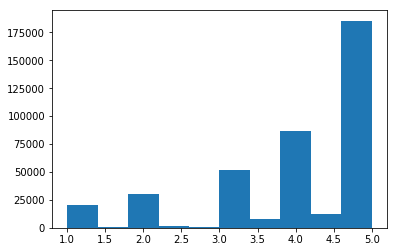

In [49]:
import matplotlib.pyplot as plt

plt.hist(ratings, bins=10)
plt.show()

Other ideas could include using a sentiment analysis on the text of reviews, using user and business categories etc.

In [35]:
# categories
categories = defaultdict(int)

for r in reviews:
    if 'categories' not in r or r['categories'] is None: continue
    
    cats = r['categories']
    if len(cats) == 0: continue
    
    for c in cats:
        categories[c] += 1

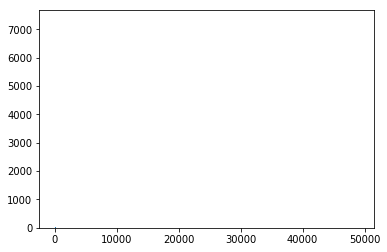

In [40]:
plt.hist(list(categories.values()), bins=len(categories))
plt.show()

In [42]:
top20 = sorted(categories.items(), key=lambda x: -x[1])[:20]

In [43]:
top20

[('Restaurant', 49063),
 ('Hotel', 23594),
 ('European Restaurant', 22735),
 ('Asian Restaurant', 20710),
 ('American Restaurant', 19027),
 ('Italian Restaurant', 18370),
 ('Bar', 15870),
 ('Pizza Restaurant', 14391),
 ('Fast Food Restaurant', 13426),
 ('Cafe', 11172),
 ('Chinese Restaurant', 9702),
 ('Mexican Restaurant', 9486),
 ('Latin American Restaurant', 8017),
 ('Used Car Dealer', 7074),
 ('Seafood Restaurant', 7053),
 ('Coffee Shop', 6933),
 ('Hamburger Restaurant', 6786),
 ('Japanese Restaurant', 6745),
 ('Pub', 6307),
 ('Park', 5584)]